In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent))
import scripts.eda_toolkit as eda
import sklearn
from sklearn.model_selection import train_test_split
import scripts.functions as fn
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
RANDOM_STATE = 8

home = Path.cwd().parent
data_dir = home / "data"
notebook_dir = home / "notebooks"
df = pd.read_csv(data_dir / "processed" / "train_data.csv")
sklearn.set_config(transform_output="pandas")

In [3]:
print(f"Training set shape: {df.shape}")

Training set shape: (841, 21)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop(columns=["class"]),
    df["class"],
    test_size=150,
    random_state=RANDOM_STATE,
    stratify=df["class"]
)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((691, 20), (691,), (150, 20), (150,))

In [4]:
X_train.head()

,checking_account_status,duration_months,credit_history,purpose,credit_amount,savings_account_bonds,present_employment_since,installment_rate_pct_of_disp_income,personal_status_sex,other_debtors_guarantors,present_residence_since,property,age_years,other_installment_plans,housing,existing_credits_count,job,people_liable_for_maintenance,telephone,foreign_worker
237,0 <= ... < 200 DM,12,existing credits paid duly,furniture/equipment,983,>= 1000 DM,< 1 year,1,female: div/sep/married,none,4,real estate,19,none,rent,1,unskilled resident,1,none,yes
278,< 0 DM,11,critical/other credits exist,car (new),3905,< 100 DM,1 <= ... < 4 years,2,male: single,none,2,real estate,36,none,rent,2,skilled employee/official,2,none,yes
482,0 <= ... < 200 DM,36,delay in paying off in past,car (new),7432,< 100 DM,1 <= ... < 4 years,2,female: div/sep/married,none,2,bldg society/life ins.,54,none,rent,1,skilled employee/official,1,none,yes
238,< 0 DM,6,critical/other credits exist,radio/television,1957,< 100 DM,4 <= ... < 7 years,1,female: div/sep/married,none,4,car or other,31,none,own,1,skilled employee/official,1,none,yes
732,< 0 DM,24,all credits here paid duly,others,1358,unknown/no savings account,>= 7 years,4,male: single,none,3,car or other,40,stores,own,1,management/self-employed/etc,1,"yes, registered",yes


### Take a look at the variables

In [ ]:
for col in train_df.columns:
    if train_df[col].dtype in [int, float]:
        eda.analyze_numerical(train_df[col])
        eda.analyze_categorical_numerical(y_train, train_df[col], parametric=False)
    else:
        eda.analyze_categorical(train_df[col])
        eda.analyze_categorical_categorical(train_df[col], y_train)

<hr>

## SVC

Baseline model + simplest transformations

In [4]:
X_baseline = pd.DataFrame(fn.BaselineEngineer().fit_transform(X_train))

In [5]:
from scripts.train_svc import svc_preprocess, train_svc


X_train_processed_svc, full_pipeline_svc = svc_preprocess(X_train, y_train)
X_train_processed_svc = pd.DataFrame(X_train_processed_svc)


basic_model_svc = SVC(random_state=RANDOM_STATE, probability=True)

basic_pipeline_svc = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_svc)
])

eng_pipeline_svc = Pipeline(steps=[
    ("full_pipeline", full_pipeline_svc),
    ("model", basic_model_svc)
])

basic_pipeline_svc.fit(X_train, y_train)
eng_pipeline_svc.fit(X_train, y_train)

X_train_processed_svc.shape, X_baseline.shape

((691, 41), (691, 61))

ROC AUC: 0.9628 ± 0.0017 (train), 0.7771 ± 0.0315 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


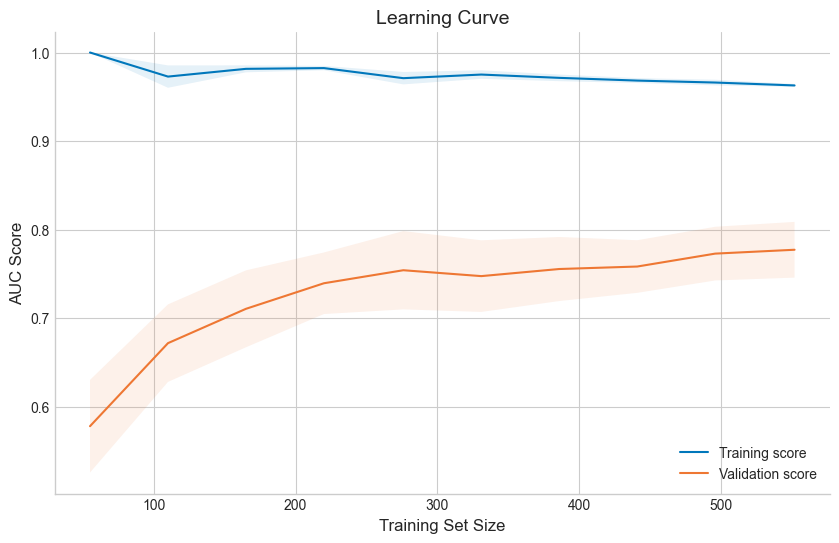

ROC AUC: 0.9258 ± 0.0026 (train), 0.7898 ± 0.0317 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


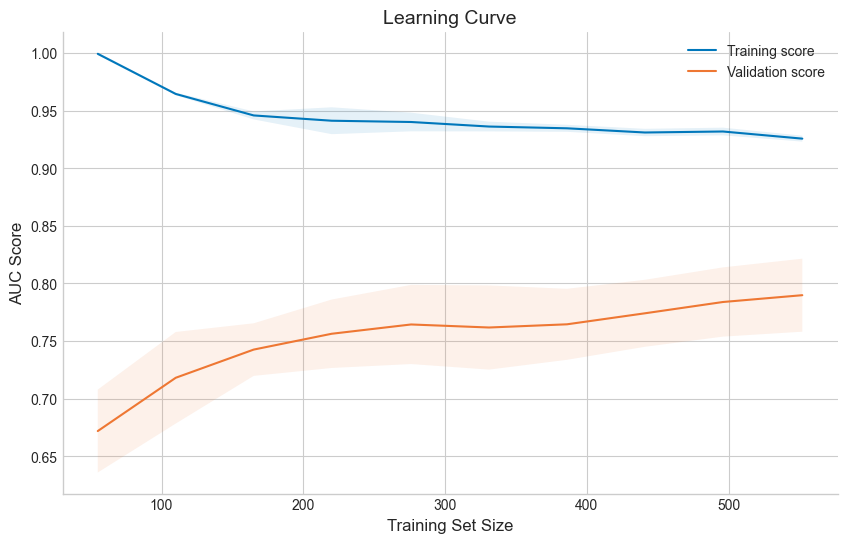

In [6]:
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")

_ , res_svc_base = fn.plot_learning_curve(basic_model_svc, X_baseline, y_train)
_ , res_svc_eng = fn.plot_learning_curve(basic_model_svc, X_train_processed_svc, y_train)

In [8]:
diff = res_svc_eng['lc_val_auc_final'] - res_svc_base['lc_val_auc_final']
print(f"Difference in ROC AUC gained from feature engineering: {diff:.4f}")

Difference in ROC AUC gained from feature engineering: 0.0127


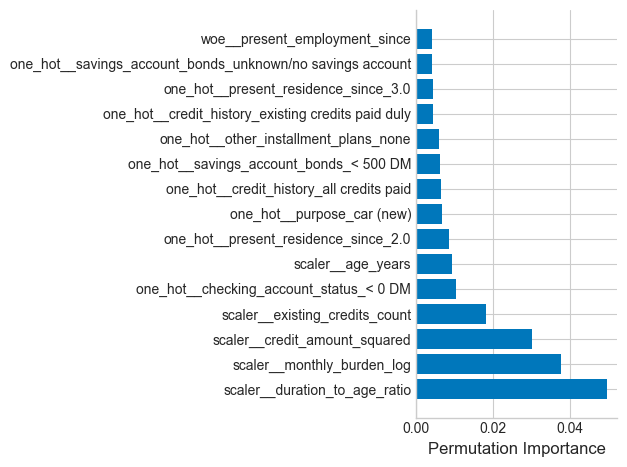

In [9]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    basic_model_svc,
    X_train_processed_svc,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fig, axes = plt.subplots()
indices = np.argsort(result.importances_mean)[::-1][:15]
axes.barh(range(15), result.importances_mean[indices])
axes.set_yticks(range(15))
axes.set_yticklabels(X_train_processed_svc.columns[indices])
axes.set_xlabel("Permutation Importance")
plt.tight_layout()
plt.show()


<hr>

## Logistic Regression

In [10]:
from scripts.train_lrc import lrc_preprocess, train_lrc
from sklearn.linear_model import LogisticRegression

X_train_processed_lrc, full_pipeline_lrc = lrc_preprocess(X_train, y_train)
X_train_processed_lrc = pd.DataFrame(X_train_processed_lrc)

basic_model_lrc = LogisticRegression(random_state=RANDOM_STATE)

basic_pipeline_lrc = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_lrc)
])

eng_pipeline_lrc = Pipeline(steps=[
    ("full_pipeline", full_pipeline_lrc),
    ("model", basic_model_lrc)
])

basic_pipeline_lrc.fit(X_train, y_train)
eng_pipeline_lrc.fit(X_train, y_train)

X_train_processed_lrc.shape, X_baseline.shape

((691, 37), (691, 61))

ROC AUC: 0.8492 ± 0.0080 (train), 0.7579 ± 0.0360 (validation)

🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning


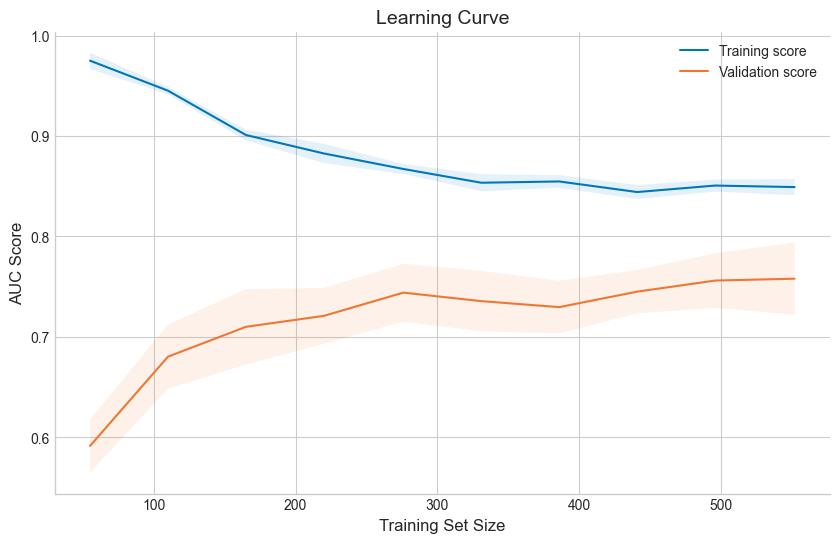

ROC AUC: 0.8331 ± 0.0056 (train), 0.7902 ± 0.0265 (validation)

🔍 DIAGNOSIS:
✅ Good bias-variance tradeoff - Ready for tuning


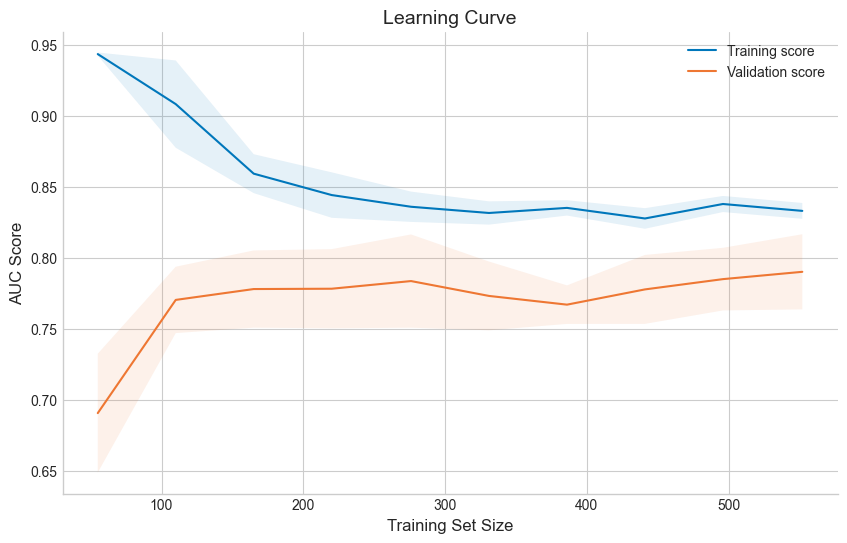

In [12]:
_ , res_lrc_base = fn.plot_learning_curve(basic_model_lrc, X_baseline, y_train)
_ , res_lrc_eng = fn.plot_learning_curve(basic_model_lrc, X_train_processed_lrc, y_train)

In [13]:
diff = res_lrc_eng['lc_val_auc_final'] - res_lrc_base['lc_val_auc_final']
print(f"Difference in ROC AUC gained from feature engineering: {diff:.4f}")

Difference in ROC AUC gained from feature engineering: 0.0323


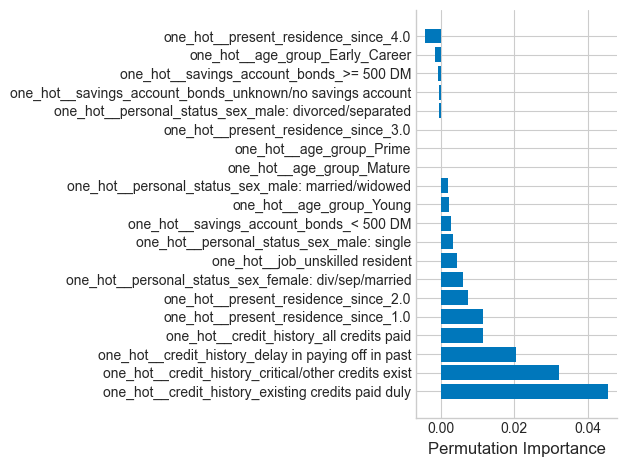

In [16]:
result = permutation_importance(
    eng_pipeline_lrc,
    X_train,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fig, axes = plt.subplots()
indices = np.argsort(result.importances_mean)[::-1][:20]
axes.barh(range(20), result.importances_mean[indices])
axes.set_yticks(range(20))
axes.set_yticklabels(X_train_processed_lrc.columns[indices])
axes.set_xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

Top 15 Most Important Features by Coefficient Magnitude:
Feature                                                Coefficient
----------------------------------------------------------------------
woe__purpose                                                0.9632
one_hot__credit_history_all credits paid                   -0.8459
woe__checking_account_status                                0.7903
one_hot__credit_history_critical/other credits exist          0.6586
woe__property                                               0.6536
woe__present_employment_since                               0.6415
count__other_installment_plans                              0.5679
one_hot__present_residence_since_2.0                       -0.4377
count__installment_rate_pct_of_disp_income                 -0.4304
one_hot__age_group_Young                                   -0.4216
one_hot__foreign_worker_no                                  0.4126
one_hot__personal_status_sex_male: single                   0.4114

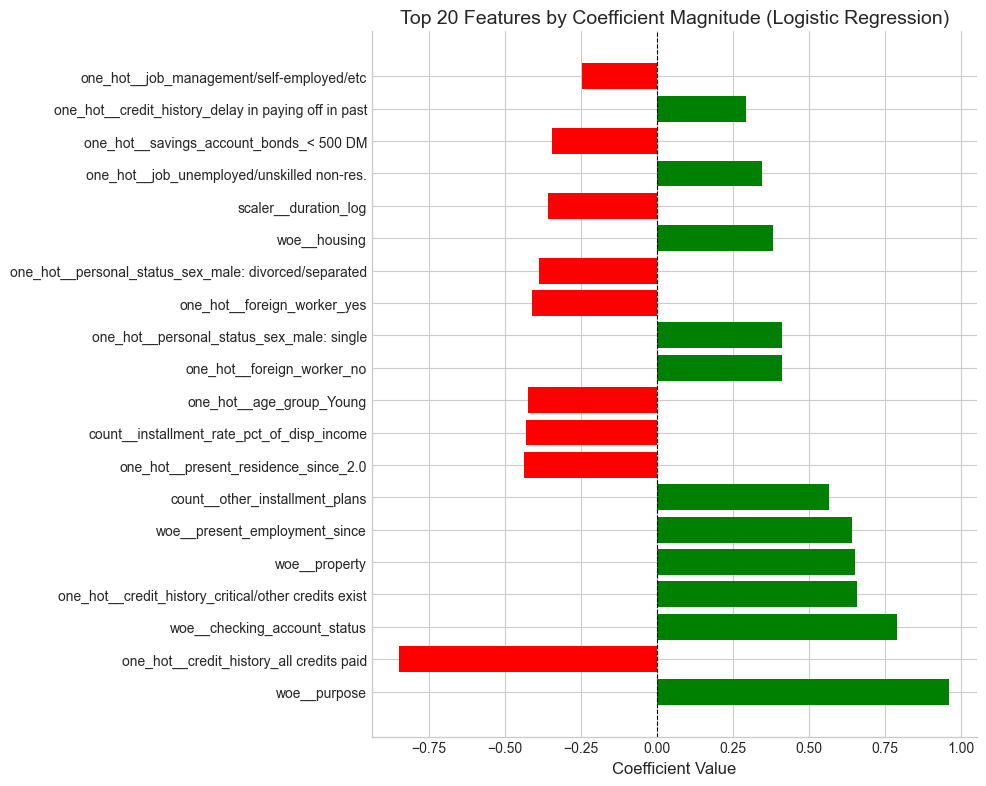

,feature,coefficient,abs_coefficient
26,woe__purpose,0.963243,0.963243
3,one_hot__credit_history_all credits paid,-0.845883,0.845883
25,woe__checking_account_status,0.790347,0.790347
1,one_hot__credit_history_critical/other credits...,0.658644,0.658644
28,woe__property,0.653583,0.653583
27,woe__present_employment_since,0.641455,0.641455
35,count__other_installment_plans,0.567926,0.567926
8,one_hot__present_residence_since_2.0,-0.437661,0.437661
34,count__installment_rate_pct_of_disp_income,-0.430447,0.430447
15,one_hot__age_group_Young,-0.421586,0.421586


In [19]:
# Get feature names and coefficients
basic_model_lrc.fit(X_train_processed_lrc, y_train)
feature_names = X_train_processed_lrc.columns
coefficients = basic_model_lrc.coef_[0]

# Create a dataframe with features and their coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

# Display top 15 most important features
print("Top 15 Most Important Features by Coefficient Magnitude:")
print("=" * 70)
print(f"{'Feature':<50} {'Coefficient':>15}")
print("-" * 70)
for idx, row in coef_df.head(15).iterrows():
    print(f"{row['feature']:<50} {row['coefficient']:>15.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_features = coef_df.head(20)
colors = ['red' if x < 0 else 'green' for x in top_features['coefficient']]
ax.barh(range(len(top_features)), top_features['coefficient'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Coefficient Value')
ax.set_title('Top 20 Features by Coefficient Magnitude (Logistic Regression)')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

coef_df

<hr>

## Random Forest

In [22]:
from scripts.train_rf import rf_preprocess
from sklearn.ensemble import RandomForestClassifier

X_train_processed_rf, full_pipeline_rf = rf_preprocess(X_train, y_train)
X_train_processed_rf = pd.DataFrame(X_train_processed_rf)

basic_model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

basic_pipeline_rf = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_rf)
])

eng_pipeline_rf = Pipeline(steps=[
    ("full_pipeline", full_pipeline_rf),
    ("model", basic_model_rf)
])

basic_pipeline_rf.fit(X_train, y_train)
eng_pipeline_rf.fit(X_train, y_train)

X_train_processed_rf.shape, X_baseline.shape

((691, 42), (691, 61))

ROC AUC: 1.0000 ± 0.0000 (train), 0.7708 ± 0.0334 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


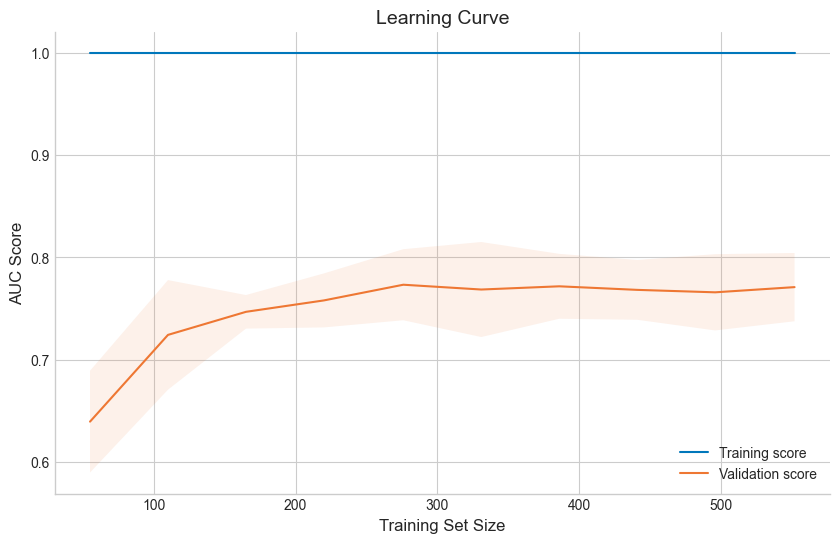

ROC AUC: 1.0000 ± 0.0000 (train), 0.7747 ± 0.0301 (validation)

🔍 DIAGNOSIS:
⚠️  High variance (overfitting) - Need regularization or more data


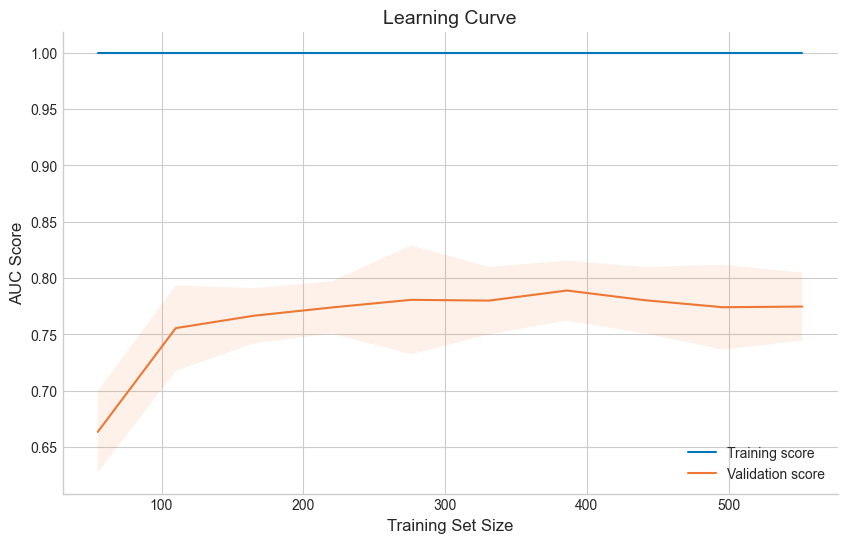

In [26]:
_ , res_rf_base = fn.plot_learning_curve(basic_model_rf, X_baseline, y_train)
_ , res_rf_eng = fn.plot_learning_curve(basic_model_rf, X_train_processed_rf, y_train)

In [27]:
diff = res_rf_eng['lc_val_auc_final'] - res_rf_base['lc_val_auc_final']
print(f"Difference in ROC AUC gained from feature engineering: {diff:.4f}")

Difference in ROC AUC gained from feature engineering: 0.0039


In [23]:
basic_pipeline_rf = Pipeline(steps=[
    ("baseline_engineer", fn.BaselineEngineer()),
    ("model", basic_model_rf)
])

basic_pipeline_rf.fit(X_train, y_train)
fn.evaluate_model(X_val, y_val, basic_pipeline_rf, "Basic RF Pipeline")


────────────────────────────────────────
Evaluation Metrics for Basic RF Pipeline:
   ROC AUC:  0.7871
   Accuracy: 0.7533
   F1:       0.8398
   Precision:0.7760

   Total Cost: 149 | Avg Cost: 0.9933



{'roc_auc': 0.7870926243567753,
 'accuracy': 0.7533333333333333,
 'f1': 0.8398268398268398,
 'precision': 0.776,
 'cost': np.int64(149),
 'avg_cost': np.float64(0.9933333333333333)}

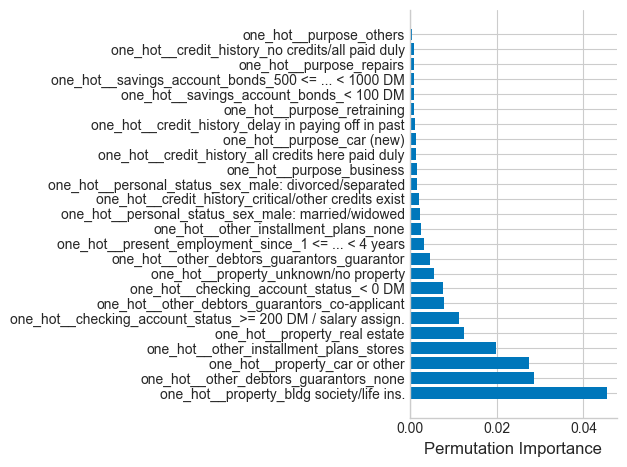

In [28]:
basic_model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
basic_model_rf.fit(X_train_processed_rf, y_train)

result = permutation_importance(
    basic_model_rf,
    X_train_processed_rf,
    y_train,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

fig, axes = plt.subplots()
indices = np.argsort(result.importances_mean)[::-1][:25]
axes.barh(range(25), result.importances_mean[indices])
axes.set_yticks(range(25))
axes.set_yticklabels(X_baseline.columns[indices])
axes.set_xlabel("Permutation Importance")
plt.tight_layout()
plt.show()

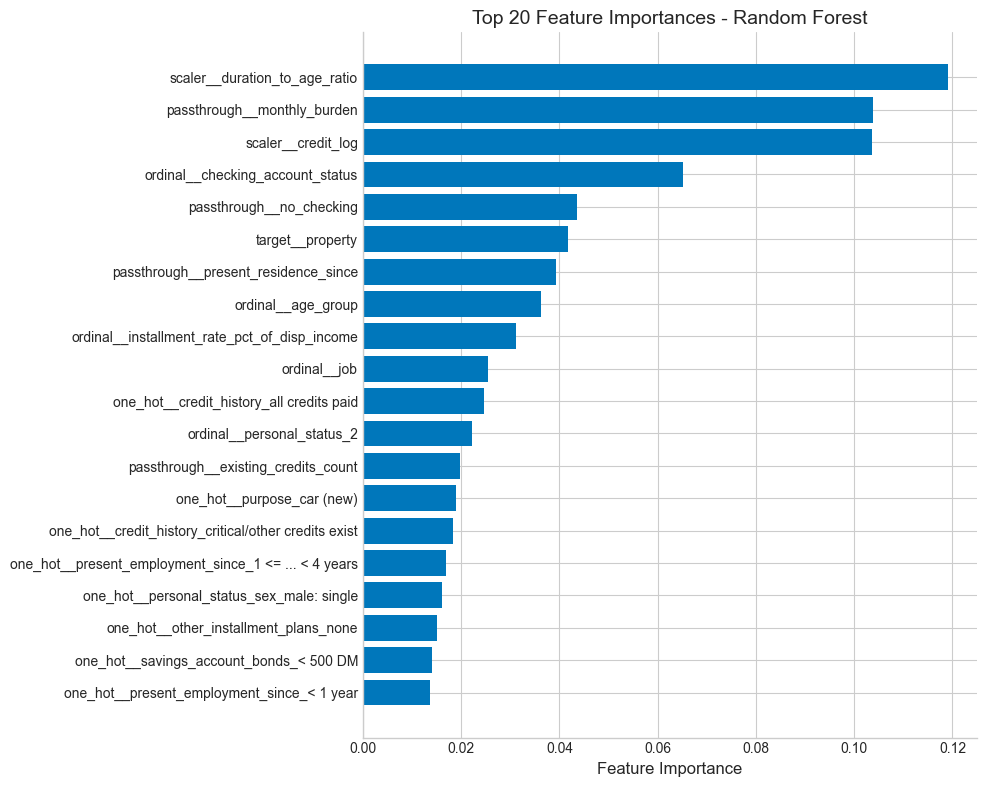


Top 10 Most Important Features:
scaler__duration_to_age_ratio                 0.1190
passthrough__monthly_burden                   0.1039
scaler__credit_log                            0.1036
ordinal__checking_account_status              0.0651
passthrough__no_checking                      0.0437
target__property                              0.0417
passthrough__present_residence_since          0.0393
ordinal__age_group                            0.0362
ordinal__installment_rate_pct_of_disp_income  0.0312
ordinal__job                                  0.0256


In [29]:
# Get feature importances from the trained model
feature_importances = basic_model_rf.feature_importances_
feature_names = X_train_processed_rf.columns

# Create a DataFrame for easier sorting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Feature Importance')
ax.set_title(f'Top {top_n} Feature Importances - Random Forest')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTop 10 Most Important Features:")
print("=" * 60)
for idx, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:<45} {row['importance']:.4f}")

<hr>

In [ ]:
cat_boost_space = {
    'depth': Integer(4,10),
    'iterations': Integer(100, 400),
    'learning_rate': Real(0.01, 0.2, prior='uniform'),
}

cat_boost_tuned = BayesSearchCV(
    estimator=CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    search_spaces=cat_boost_space,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

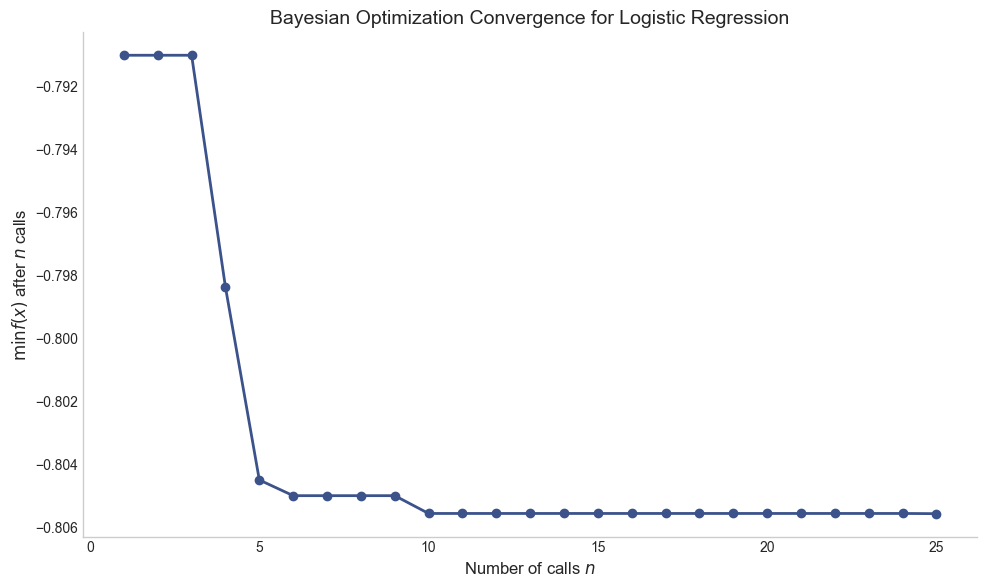

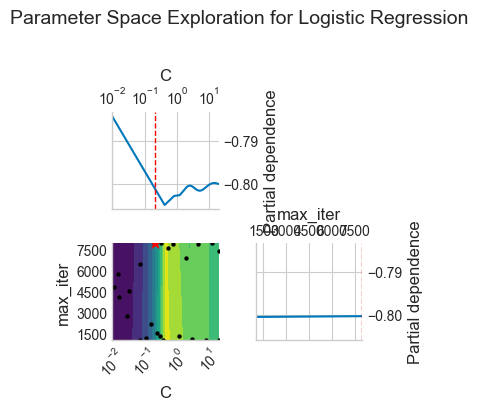

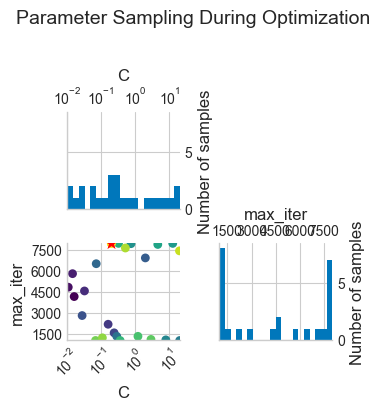


Best ROC-AUC Score: 0.8056

Best Parameters:
  C: 0.20257899368793866
  max_iter: 8000
  penalty: l2
  solver: liblinear


In [57]:
from skopt.plots import plot_objective, plot_evaluations, plot_convergence

import matplotlib.pyplot as plt

# Plot convergence - shows how the optimization improved over iterations
fig, ax = plt.subplots(figsize=(10, 6))
plot_convergence(log_reg_tuned.optimizer_results_[0])
plt.title('Bayesian Optimization Convergence for Logistic Regression', fontsize=14)
plt.tight_layout()
plt.show()

# Plot objective function - shows parameter importance and interactions
fig = plot_objective(log_reg_tuned.optimizer_results_[0], 

                     n_points=50)
plt.suptitle('Parameter Space Exploration for Logistic Regression', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Plot evaluations - shows how parameters were sampled during optimization
fig = plot_evaluations(log_reg_tuned.optimizer_results_[0])

plt.suptitle('Parameter Sampling During Optimization', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print best parameters and score
print(f"\nBest ROC-AUC Score: {log_reg_tuned.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in log_reg_tuned.best_params_.items():
    print(f"  {param}: {value}")

In [21]:
def check_feature_target_correlation(X, y, method='auto'):
    """
    Check correlation between features and target variable.
    Handles both numeric and categorical features appropriately.
    
    Parameters:
    -----------
    X : pd.DataFrame - Feature matrix
    y : pd.Series - Target variable
    method : str - Correlation method:
        - 'auto': Automatically choose based on feature type
        - 'point_biserial': For numeric features with binary target
        - 'cramers_v': For categorical features with categorical target
    
    Returns:
    --------
    pd.DataFrame - Correlations sorted by absolute value
    """
    from scipy.stats import pointbiserialr, chi2_contingency
    
    def cramers_v(x, y):
        """Calculate Cramér's V statistic for categorical-categorical association."""
        contingency_table = pd.crosstab(x, y)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        if min_dim == 0:
            return 0, p_value
        v = np.sqrt(chi2 / (n * min_dim))
        return v, p_value
    
    correlations = []
    
    for col in X.columns:
        try:
            # Check if column is numeric
            if pd.api.types.is_numeric_dtype(X[col]):
                # Use point-biserial for numeric features
                # Drop NaN values for calculation
                mask = ~(X[col].isna() | y.isna())
                corr, p_value = pointbiserialr(y[mask], X[col][mask])
                method_used = 'point_biserial'
            else:
                # Use Cramér's V for categorical features
                corr, p_value = cramers_v(X[col].astype(str), y)
                method_used = 'cramers_v'
            
            correlations.append({
                'feature': col,
                'correlation': corr,
                'abs_correlation': abs(corr),
                'p_value': p_value,
                'significant': p_value < 0.05,
                'method': method_used,
                'dtype': str(X[col].dtype)
            })
        except Exception as e:
            print(f"⚠️ Could not calculate correlation for '{col}': {e}")
            correlations.append({
                'feature': col,
                'correlation': np.nan,
                'abs_correlation': np.nan,
                'p_value': np.nan,
                'significant': False,
                'method': 'error',
                'dtype': str(X[col].dtype)
            })
    
    # Create DataFrame and sort by absolute correlation
    corr_df = pd.DataFrame(correlations)
    corr_df = corr_df.sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    
    # Print results
    print("=" * 85)
    print(f"FEATURE-TARGET CORRELATION ANALYSIS")
    print("=" * 85)
    print(f"\n{'Feature':<30} {'Correlation':>10} {'P-value':>10} {'Sig?':>6} {'Method':>15}")
    print("-" * 85)
    
    for _, row in corr_df.iterrows():
        sig_marker = "✓" if row['significant'] else "✗"
        corr_val = f"{row['correlation']:.4f}" if pd.notna(row['correlation']) else "N/A"
        p_val = f"{row['p_value']:.4f}" if pd.notna(row['p_value']) else "N/A"
        print(f"{row['feature']:<30} {corr_val:>10} {p_val:>10} {sig_marker:>6} {row['method']:>15}")
    
    # Summary
    print("\n" + "=" * 85)
    print("SUMMARY")
    print("=" * 85)
    
    valid_corr = corr_df[corr_df['abs_correlation'].notna()]
    strong = valid_corr[valid_corr['abs_correlation'] >= 0.3]
    moderate = valid_corr[(valid_corr['abs_correlation'] >= 0.1) & (valid_corr['abs_correlation'] < 0.3)]
    weak = valid_corr[valid_corr['abs_correlation'] < 0.1]
    
    print(f"\n📊 Methods used:")
    print(f"   • Point-biserial (numeric features): {len(corr_df[corr_df['method'] == 'point_biserial'])}")
    print(f"   • Cramér's V (categorical features): {len(corr_df[corr_df['method'] == 'cramers_v'])}")
    
    print(f"\n🔴 Strong correlation (|r| >= 0.3): {len(strong)} features")
    if len(strong) > 0:
        print(f"   → {', '.join(strong['feature'].tolist())}")
    
    print(f"🟡 Moderate correlation (0.1 <= |r| < 0.3): {len(moderate)} features")
    if len(moderate) > 0:
        print(f"   → {', '.join(moderate['feature'].tolist())}")
    
    print(f"🟢 Weak correlation (|r| < 0.1): {len(weak)} features")
    
    not_significant = corr_df[~corr_df['significant'] & corr_df['p_value'].notna()]
    if len(not_significant) > 0:
        print(f"\n⚠️ Non-significant correlations (p >= 0.05): {len(not_significant)}")
        print(f"   → {', '.join(not_significant['feature'].tolist())}")
    
    return corr_df


def check_multicollinearity(X, threshold=0.7, vif_threshold=5.0):
    """
    Check multicollinearity between features using correlation matrix and VIF.
    
    Parameters:
    -----------
    X : pd.DataFrame - Feature matrix (numeric columns only)
    threshold : float - Correlation threshold to flag high correlation (default: 0.7)
    vif_threshold : float - VIF threshold to flag multicollinearity (default: 5.0)
    
    Returns:
    --------
    dict - Dictionary with correlation pairs and VIF values
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Select only numeric columns
    numeric_X = X.select_dtypes(include=[np.number])
    
    print("=" * 70)
    print("MULTICOLLINEARITY ANALYSIS")
    print("=" * 70)
    
    if len(numeric_X.columns) == 0:
        print("\n⚠️ No numeric columns found in the dataset!")
        return {'high_correlation_pairs': None, 'vif_scores': None, 'features_to_drop': []}
    
    print(f"\n📌 Analyzing {len(numeric_X.columns)} numeric features")
    
    # 1. Correlation Matrix Analysis
    print(f"\n📊 CORRELATION ANALYSIS (threshold: |r| >= {threshold})")
    print("-" * 70)
    
    corr_matrix = numeric_X.corr()
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= threshold:
                high_corr_pairs.append({
                    'feature_1': corr_matrix.columns[i],
                    'feature_2': corr_matrix.columns[j],
                    'correlation': corr_val
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        high_corr_df = high_corr_df.sort_values('correlation', key=abs, ascending=False)
        
        print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs:\n")
        print(f"{'Feature 1':<25} {'Feature 2':<25} {'Correlation':>12}")
        print("-" * 65)
        for _, row in high_corr_df.iterrows():
            print(f"{row['feature_1']:<25} {row['feature_2']:<25} {row['correlation']:>12.4f}")
    else:
        print(f"✅ No feature pairs with correlation >= {threshold}")
        high_corr_df = pd.DataFrame()
    
    # 2. Variance Inflation Factor (VIF) Analysis
    print(f"\n📊 VIF ANALYSIS (threshold: VIF >= {vif_threshold})")
    print("-" * 70)
    
    # Handle potential issues with VIF calculation
    try:
        # Remove constant columns and handle NaN
        X_clean = numeric_X.dropna()
        X_clean = X_clean.loc[:, X_clean.std() > 0]  # Remove zero-variance columns
        
        if len(X_clean.columns) > 1:
            vif_data = []
            for i, col in enumerate(X_clean.columns):
                try:
                    vif = variance_inflation_factor(X_clean.values, i)
                    vif_data.append({'feature': col, 'VIF': vif})
                except Exception as e:
                    vif_data.append({'feature': col, 'VIF': np.nan})
            
            vif_df = pd.DataFrame(vif_data)
            vif_df = vif_df.sort_values('VIF', ascending=False).reset_index(drop=True)
            
            print(f"\n{'Feature':<35} {'VIF':>12} {'Status':>15}")
            print("-" * 65)
            
            for _, row in vif_df.iterrows():
                if pd.isna(row['VIF']):
                    status = "⚠️ Error"
                elif row['VIF'] >= 10:
                    status = "🔴 High"
                elif row['VIF'] >= vif_threshold:
                    status = "🟡 Moderate"
                else:
                    status = "🟢 OK"
                print(f"{row['feature']:<35} {row['VIF']:>12.2f} {status:>15}")
            
            high_vif = vif_df[vif_df['VIF'] >= vif_threshold]
        else:
            print("⚠️ Not enough features to calculate VIF")
            vif_df = pd.DataFrame()
            high_vif = pd.DataFrame()
    except Exception as e:
        print(f"⚠️ Error calculating VIF: {e}")
        vif_df = pd.DataFrame()
        high_vif = pd.DataFrame()
    
    # 3. Recommendations
    print("\n" + "=" * 70)
    print("RECOMMENDATIONS")
    print("=" * 70)
    
    features_to_drop = set()
    
    # Based on correlation
    if len(high_corr_pairs) > 0:
        print("\n📌 Based on HIGH CORRELATION:")
        for pair in high_corr_pairs:
            f1, f2 = pair['feature_1'], pair['feature_2']
            print(f"   • Consider dropping one of: '{f1}' or '{f2}' (r = {pair['correlation']:.4f})")
            # Suggest dropping the one with lower variance (less information)
            if numeric_X[f1].std() < numeric_X[f2].std():
                features_to_drop.add(f1)
                print(f"     → Suggestion: Drop '{f1}' (lower variance)")
            else:
                features_to_drop.add(f2)
                print(f"     → Suggestion: Drop '{f2}' (lower variance)")
    
    # Based on VIF
    if len(high_vif) > 0:
        print("\n📌 Based on HIGH VIF:")
        for _, row in high_vif.iterrows():
            print(f"   • '{row['feature']}' has VIF = {row['VIF']:.2f}")
            features_to_drop.add(row['feature'])
    
    if features_to_drop:
        print(f"\n🎯 SUGGESTED FEATURES TO DROP: {list(features_to_drop)}")
        print(f"\n   Code to drop: X = X.drop(columns={list(features_to_drop)})")
    else:
        print("\n✅ No multicollinearity issues detected!")
    
    return {
        'high_correlation_pairs': high_corr_df if len(high_corr_pairs) > 0 else None,
        'vif_scores': vif_df if len(vif_df) > 0 else None,
        'features_to_drop': list(features_to_drop)
    }

<hr>

In [ ]:
# After final model selection, check stability:

final_model = CatBoostClassifier(**best_params)

# Test across multiple seeds to report uncertainty
seed_results = []
for seed in [42, 123, 456, 789, 999]:
    model = final_model.set_params(random_state=seed)
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    seed_results.append(cv_score.mean())

print(f"Mean AUC: {np.mean(seed_results):.4f}")
print(f"Std AUC: {np.std(seed_results):.4f}")
print(f"Range: [{np.min(seed_results):.4f}, {np.max(seed_results):.4f}]")

# Expected for 700 samples:
# Std ~0.01-0.02 (1-2% variation)
# This is just reporting stability, not model selection

<hr>

## Model training

In [72]:
xgb_clf = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgb_bayes_search = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=xgb_space,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)

NameError: name 'BayesSearchCV' is not defined

<hr>